In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 16)

FILENAME = 'images/bone247_bse_image1.tif'

**Read grayscale image, apply histogram equalization.**

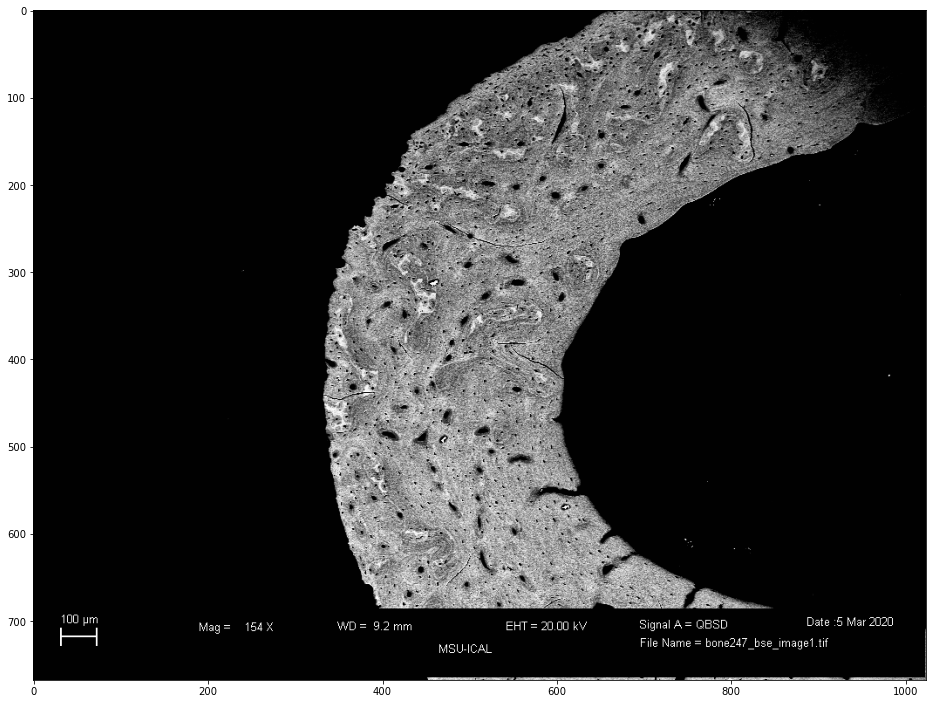

In [2]:
## Read grayscale image, 
img = cv2.imread(FILENAME, cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(32,32))
equalized = clahe.apply(img)

plt.imshow(equalized, cmap = 'gray')
plt.show()

**Filter To Drop Shadows, Pre-Process Bone Isolation**

* May want to use additional histogram based approaches here!

In [3]:
# Truncate all image values below threshold
ret,truncd = cv2.threshold(equalized,127,255,cv2.THRESH_TRUNC)

# Take 5x5 pixel normalized average across image
blur = cv2.GaussianBlur(truncd,(5,5),0)

# Apply binary threshold, Otsu threshold
ret3,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Filter morphology - close gaps
kernel = np.ones((7,7),np.uint8)
closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

**Use Recursive convex hull to identify bone in image**

62


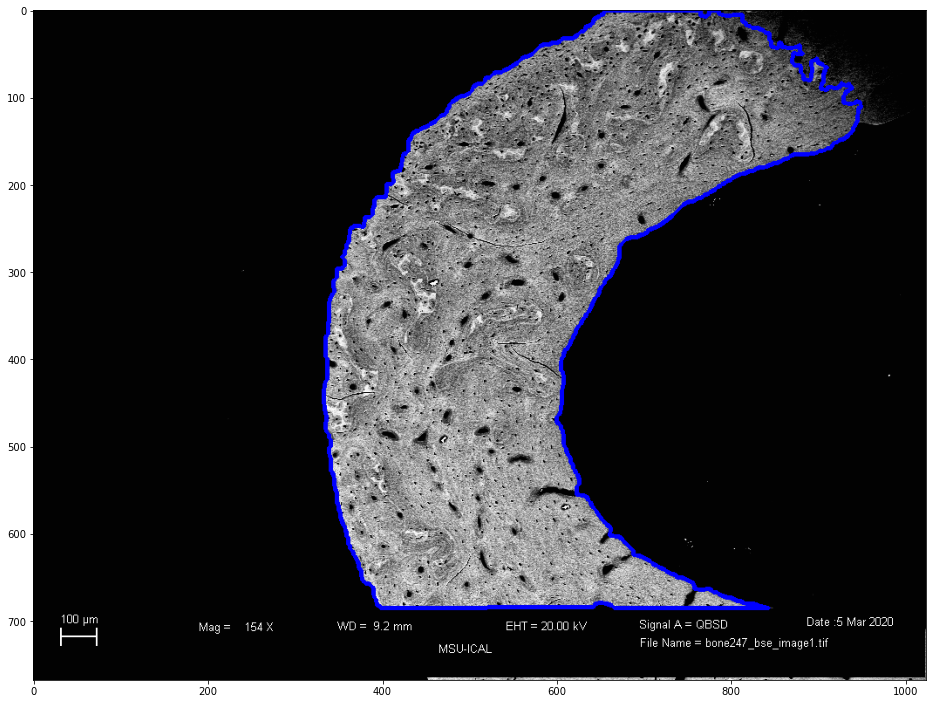

In [4]:
## Contour to find bone region

contours, hierarchy = cv2.findContours(closing,
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_TC89_L1)

areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
print(max_index)

color_img = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
out = cv2.drawContours(color_img, contours, max_index, (0,0,255), 3)
plt.imshow(out)
plt.show()

**Isolate bone**

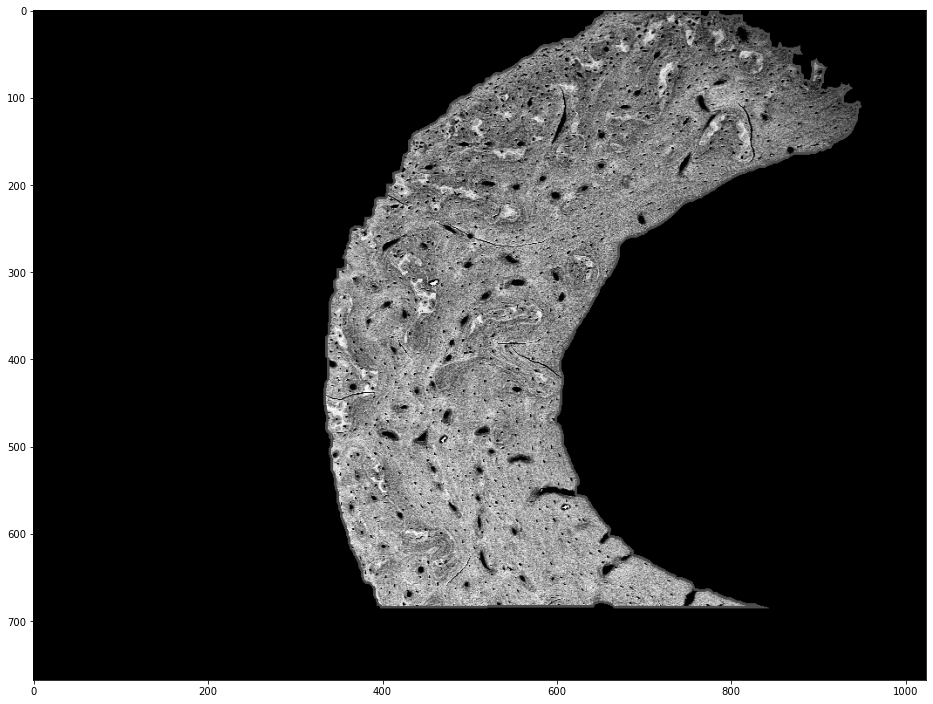

In [5]:
bone = contours[max_index]

fill_color = [0,0,0]
mask_value = 255

stencil = np.zeros(color_img.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, [bone], mask_value)

sel = (stencil != mask_value)
color_img[sel] = fill_color

BASE_IMG = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
plt.imshow(BASE_IMG, cmap = 'gray')
plt.show()

**Apply Contrast Filtering to highlight contiguous bone/adjust shadows**

* nothing actually done here yet, can just do color quantization by itself? 

**Apply Color Quantization**

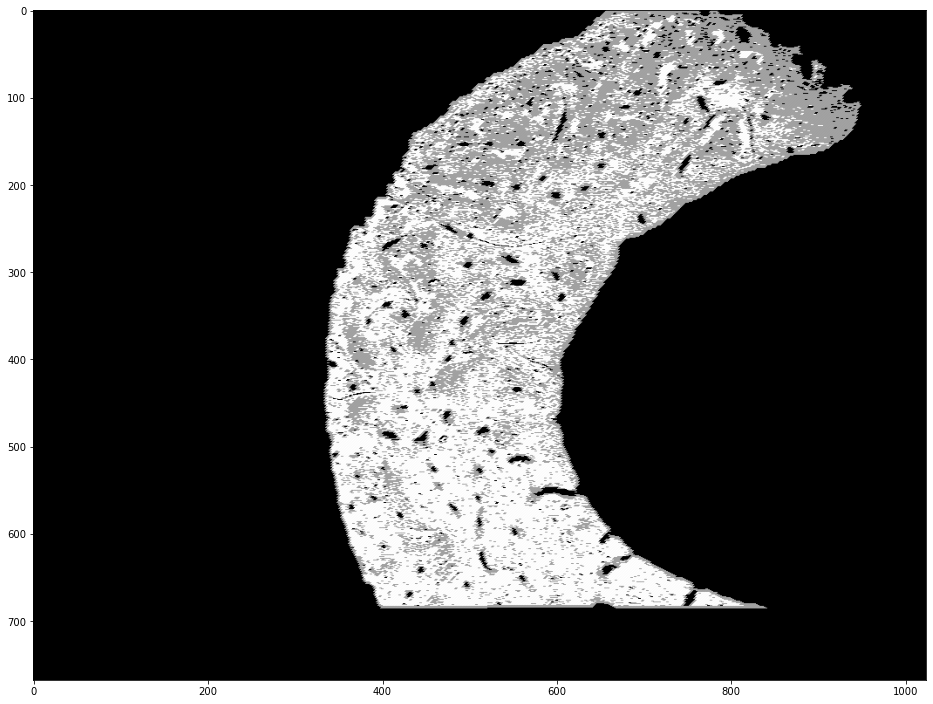

In [6]:
img = BASE_IMG.copy()
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,
                            cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2, cmap = 'gray')
plt.show()